### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper,shrinkBigKTransformer,logminus_T,exp_T,logminplus1_T,none_T

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

DATA UPLOAD
- user uploads data
   - calculate n,k
   - calculate sparsity of y
   - calculate missing values of x by column
   - calcualte missing values of x by row
   - calculate n if rows with missing vals dropped
   - calculate rank of resulting matrix (k_drop_r)
   
- Train/test split






In [3]:
test_share=0.2 
cv_folds=10
cv_reps=20
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=80,
                          n_features=5, # x variables generated and returned 
                          n_informative=2, # x variables included in the actual model of y
                          effective_rank=2, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=0.5,
                          random_state=rs,
                          bias=0)

xt=np.product(X[:,1:3],axis=-1)
print(xt.shape)
xtnorm=xt/np.max(xt)
#print(xtnorm.shape)
xb=xtnorm*7

y=X[:,1:4]@np.array([3,-5,2])[:,None]+0.5*y[:,None]
#print(y.shape)
y=y[:,0]+xb
#print(y.shape)
y=np.exp(y)
#print(y.shape)

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

In [7]:
n,k=X_train.shape

max_k=n//4

vbhelper.max_k=max_k

## Model Selection
### define estimators
#### example:
 - make_pipeline(
   - handle missing values,
     - global: drop_rows or impute 
       - could also look for columns with many missing vals first
     - set cv_drop_rows variable if rows are dropped to make sure GBR doesn't use those in cross validation
   
   - make transformed columns,
   - Multi CV (make our own wrapper that chooses the best of model variations)
     - modify model (e.g., transform Y)
       - combined selection/estimation (e.g., lars(https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression))
       - pre-select-features -> CV estimate
         - for lin reg with k>n, 
           - select features k << n
           - project data such that k << n
   - set final model as best in the pipeline based on chosen loss (mse default for continuous y)
   
   

   


In [8]:
# use lambda to make a callable object for creating new models, but with args set already
# may be unnecessary due to sklearn cloning


linear_regression=lambda: make_pipeline(StandardScaler(),LinearRegression(fit_intercept=1)) 
linear_regression_lars=lambda: make_pipeline(StandardScaler(),shrinkBigKTransformer(max_k=max_k),LinearRegression()) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
elastic_net =lambda: make_pipeline(StandardScaler(), ElasticNetCV())
linear_svr =lambda: make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=lambda: make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(GradientBoostingRegressor())

g_pts=3 # grid points for gridsearchcv param_grid 
linear_svr = Pipeline(steps=[('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=10000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,2,g_pts)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=10000, cache_size=2*10**3))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,g_pts),'rbf_svr__gamma':np.logspace(-1,0.5,g_pts)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


In [9]:
transformer_list=[logminplus1_T(),none_T(),logminus_T()]#exp_T()] # imported...
lin_reg_y_t_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=linear_regression_lars()))])
lin_reg_y_t_param_grid={'ttr__transformer':transformer_list}
lin_reg_y_transform=lambda: GridSearchCV(lin_reg_y_t_pipe,param_grid=lin_reg_y_t_param_grid)

#### add PolynomialFeatures() to gridsearch
#### and try shrinking the number of parameters

In [10]:
steps=[
    ('scaler',StandardScaler()),
    ('shrink_k',shrinkBigKTransformer()),
    ('polyfeat',PolynomialFeatures(interaction_only=1,include_bias=0)),
    ('lin-reg',LinearRegression())]

lin_reg_Xy_t_pipe=Pipeline(steps=steps)
k1=min([k,max_k])
lin_reg_Xy_t_param_grid={'ttr__transformer':transformer_list,
                        'polyfeat__degree':[1,2],
                        'shrink_k__max_k':np.array(range(2,k1+1,k1//3))}
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=2, random_state=rs) 
lin_reg_Xy_transform=lambda: GridSearchCV(lin_reg_y_t_pipe,param_grid=lin_reg_y_t_param_grid,cv=cv)

In [11]:
estimator_dict={'linear-regression':linear_regression,
                'linear-regression-lars':linear_regression_lars,
                'lin_reg_y_transform':lin_reg_y_transform,
                'lin_reg_Xy_transform':lin_reg_Xy_transform,
                'elastic-net':elastic_net, 
                'linear-svr-cv':linear_svr_cv, }
                #'rbf-svr-cv':rbf_svr_cv, 
                #'gradient-boosting-reg':gradient_boosting_reg}
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [12]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [13]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [14]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [15]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-903695807.9308043
    linear-regression-lars:-903695807.9308043
    lin_reg_y_transform:-885238729.8739288
    lin_reg_Xy_transform:-885238729.8739288
    elastic-net:-861632195.1153566
    linear-svr-cv:-897962640.8497332
scores for scorer: neg_mean_absolute_error:
    linear-regression:-16305.871937696189
    linear-regression-lars:-16305.871937696189
    lin_reg_y_transform:-6629.610742279873
    lin_reg_Xy_transform:-6629.610742279873
    elastic-net:-11655.965335722356
    linear-svr-cv:-6655.569325714623
scores for scorer: r2:
    linear-regression:-15085913887.787502
    linear-regression-lars:-15085913887.787512
    lin_reg_y_transform:-217423.2764503454
    lin_reg_Xy_transform:-217423.2764503454
    elastic-net:-1700864515.6722033
    linear-svr-cv:-25600.301076914948


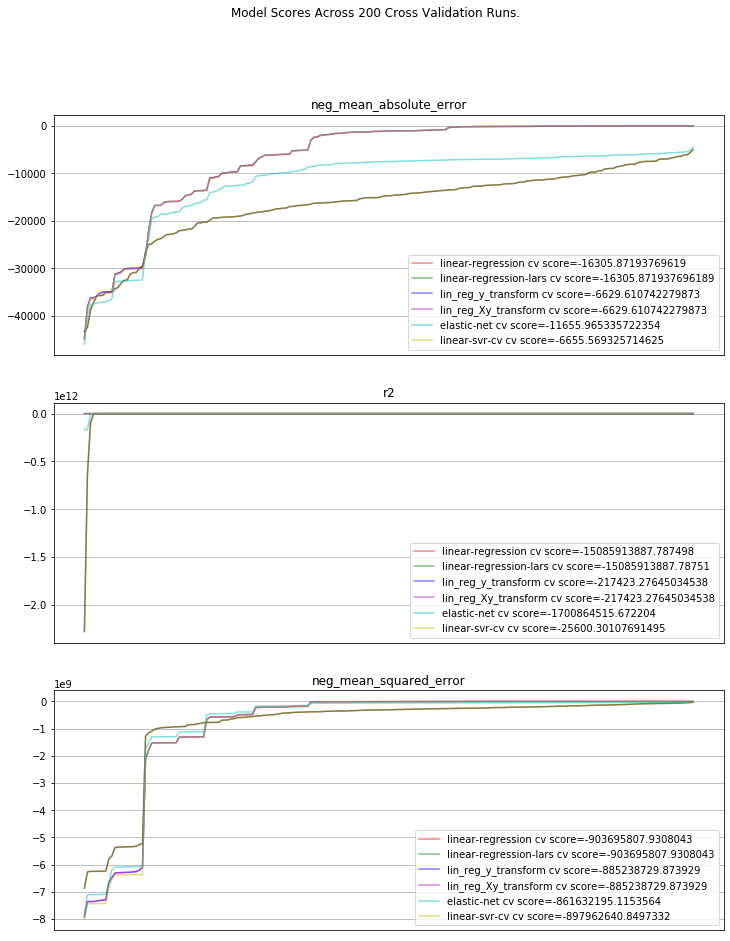

In [16]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [17]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [18]:
final_estimator_name='linear-regression-lars'

In [19]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [20]:
printTestandCVScores(final_estimator_name,cv_score_dict_means)

test set: negative-mse=-722270079.0986104
cv avg: neg_mean_squared_error= -903695807.9308043
cv avg: neg_mean_absolute_error= -16305.871937696189
cv avg: r2= -15085913887.787512
coefficients:  [ 2934.81475922 -8126.13441911 -2869.97362035  8861.80372341
  3583.73459377]
intercept:  6756.499001018759


In [21]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

test set: negative-mse=-735167401.5819484
cv avg: neg_mean_squared_error= -861632195.1153566
cv avg: neg_mean_absolute_error= -11655.965335722356
cv avg: r2= -1700864515.6722033
coefficients:  [ 358.88926971 -444.80255268 -127.44316035  888.32316423  543.87087815]
intercept:  6756.499001018759


In [22]:
printTestandCVScores('lin_reg_Xy_transform',cv_score_dict_means)

test set: negative-mse=-815541163.7522459
cv avg: neg_mean_squared_error= -885238729.8739288
cv avg: neg_mean_absolute_error= -6629.610742279873
cv avg: r2= -217423.2764503454


## Next Steps
- ### add options for dealing with important but underrepresented values of Y
- ### construct model averaging using average cross validation scores
- ### predict with confidence intervals 
  -    #### could use variability from cv
  -   #### some algorithms have their own method
